# Libraries

In [29]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras



import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.metrics import RootMeanSquaredError

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

import json

import os

from google.colab import drive
import os

In [30]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ts')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Extraction

In [31]:
df_1 = pd.read_csv('15900000-16200000.csv', parse_dates=["# datetime"], index_col = "# datetime")
df_1.index.names = ['dt']
df_1.columns = ["n_txn", "eth", "limit", "gas"]
del df_1["limit"]

df_2 = pd.read_csv('162000000-16440000.csv', parse_dates=["# datetime"], index_col = "# datetime")
df_2.index.names = ['dt']
df_2.columns = ["n_txn", "eth", "limit", "gas"]
del df_2["limit"]

df_3 = pd.read_csv('16440000-16500000.csv', parse_dates=["# datetime"], index_col = "# datetime")
df_3.index.names = ['dt']
df_3.columns = ["n_txn", "eth", "limit", "gas"]
del df_3["limit"]


df = pd.concat([df_1, df_2, df_3], axis = 0)

In [32]:
df.head() 

,n_txn,eth,gas
dt,,,
2022-11-05 00:40:47,140,1647.492702,1.050702e+10
2022-11-05 00:40:59,133,1647.493372,1.031394e+10
2022-11-05 00:41:11,133,1647.493372,1.156523e+10
2022-11-05 00:41:23,120,1647.504291,1.130654e+10
2022-11-05 00:41:35,129,1646.815941,1.118033e+10


In [33]:
df["gas"] = df["gas"] / 1000000000
df.index = pd.to_datetime(df.index)
df = df.resample('1T').mean()
df = df[["gas"]]

In [34]:
df.head()

,gas
dt,
2022-11-05 00:40:00,10.410478
2022-11-05 00:41:00,11.395897
2022-11-05 00:42:00,11.727410
2022-11-05 00:43:00,10.569524
2022-11-05 00:44:00,11.760463


Train Test Split

In [35]:
n = len(df)
train_df = df[0:int(n*0.8)]
test_df = df[int(n*0.8):]

# Pre Processing

In [36]:
# eliminate all value that are above a certain threshold

train_df = train_df.loc[train_df["gas"] < 300]

<Axes: xlabel='dt'>

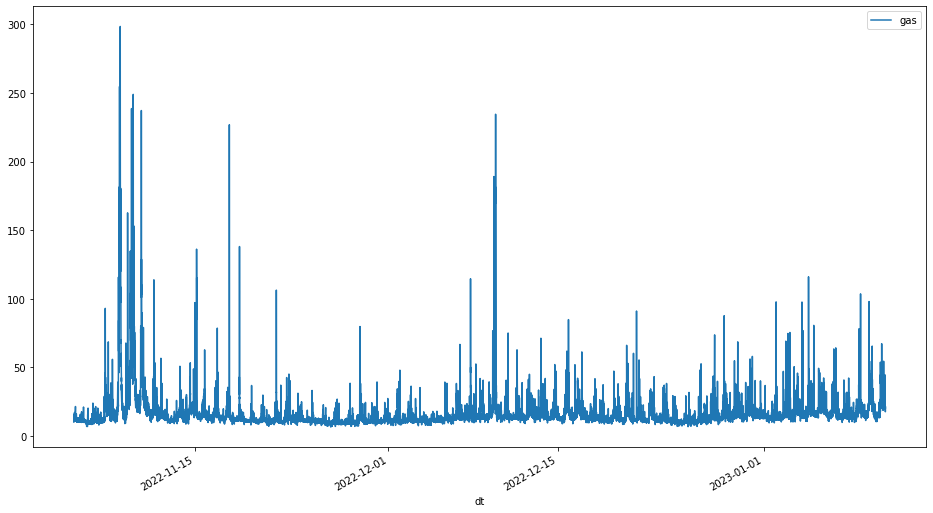

In [37]:
train_df.plot(figsize = (16, 9))

Check Stationarity

In [38]:
def check_stationarity(data):
    result = adfuller(data['gas'])
    print('ADF Statistic: {:.3f}'.format(result[0]))
    print('p-value: {:.3f}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.3f}'.format(key, value))
    if result[1] > 0.05:
        print('The time series is not stationary.')
    else:
        print('The time series is stationary.')

In [42]:
check_stationarity(train_df)

ADF Statistic: -15.394
p-value: 0.000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
The time series is stationary.


Check Autocorrelation

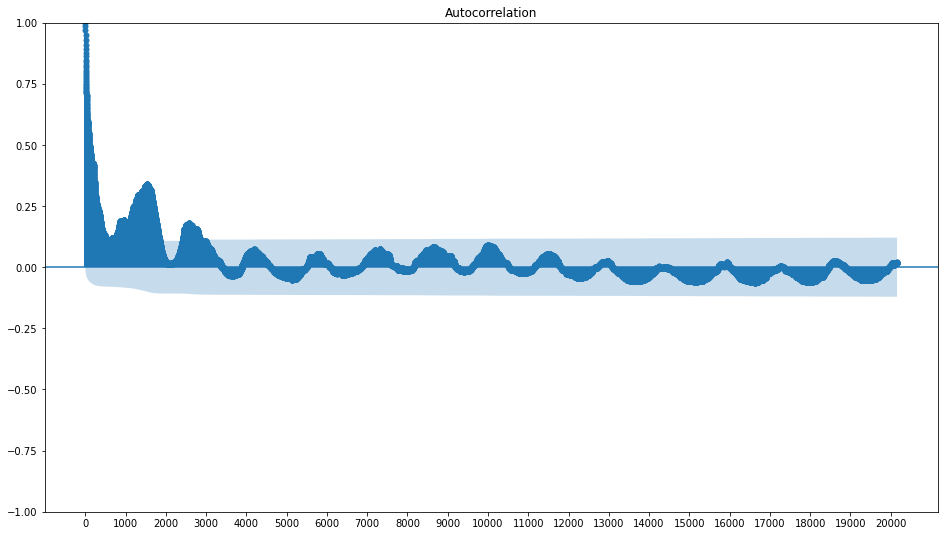

In [39]:
fig, ax = plt.subplots(figsize=(16, 9))
lags = 20160
plot_acf(train_df['gas'], lags=20160, ax = ax) # 2 weeks in minutes
plt.xticks(range(0, lags, 1000))
plt.savefig("acf")
plt.show()

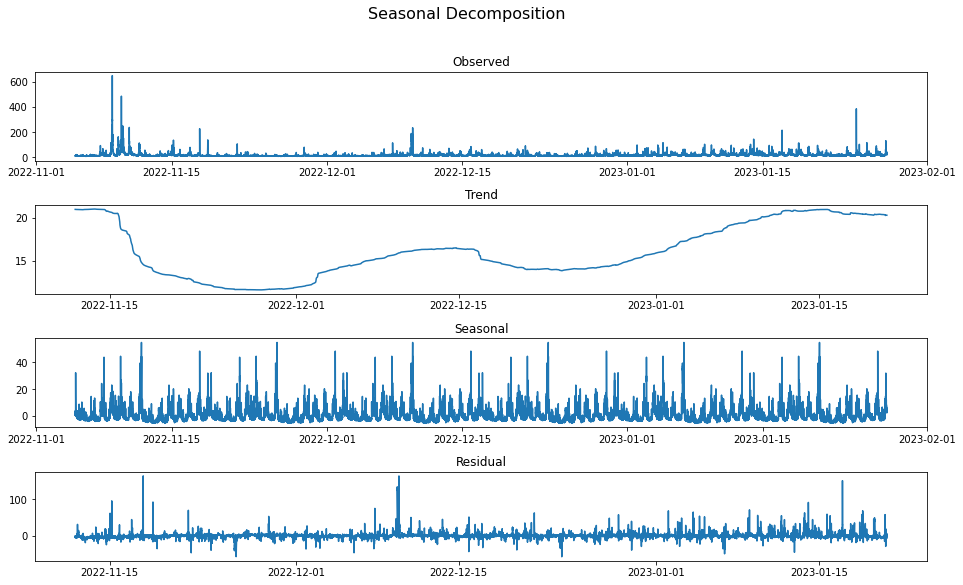

In [43]:
plt.rcParams['figure.figsize'] = [16, 9]


decomposition = seasonal_decompose(df["gas"], model='additive', period=lags)

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16, 9))
axes[0].plot(decomposition.observed)
axes[0].set_title("Observed")
axes[1].plot(decomposition.trend)
axes[1].set_title("Trend")
axes[2].plot(decomposition.seasonal)
axes[2].set_title("Seasonal")
axes[3].plot(decomposition.resid)
axes[3].set_title("Residual")
fig.suptitle("Seasonal Decomposition", fontsize=16)
fig.subplots_adjust(hspace=0.5)
plt.savefig("trends.png", dpi=300)
plt.show()

In [44]:
mean = decomposition.resid.mean()
std = decomposition.resid.std()
autocorrelation = decomposition.resid.autocorr()

print(f"Residual mean: {mean}")
print(f"Residual standard deviation: {std}")
print(f"Residual autocorrelation: {autocorrelation}")

Residual mean: -0.2998301907494508
Residual standard deviation: 6.860316381627869
Residual autocorrelation: 0.96871395082133


## Windowing

In [45]:
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
     break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
    
  return np.array(X), np.array(y)

In [59]:
# choose a number of time steps
n_steps = 3
n_features = 1

X_train, y_train = split_sequence(train_df["gas"], n_steps)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train_reshaped = y_train.reshape(y_train.shape[0], 1)

X_test, y_test = split_sequence(test_df["gas"], n_steps)
X_test_reshaped = X_test.reshape((X_test.shape[0], X_train.shape[1], n_features))
y_test_reshaped = y_test.reshape(y_test.shape[0], 1)

In [47]:
MAX_EPOCHS = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

In [48]:
def single_compile_fit(model, X_train_reshaped, y_train, checkpoint_path):

  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_path,
      save_weights_only=True,
      save_best_only=True,
      monitor='val_loss',
      mode='min',
      verbose=1
  )

  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()])
  history = model.fit(
      X_train_reshaped, y_train,
      batch_size=32, epochs=MAX_EPOCHS,
      validation_split=0.2, shuffle=False,
      callbacks=[early_stopping, checkpoint_callback]
  )

  return history

In [49]:
def metrics(model):

  MSE = mean_squared_error(model.predict(X_test_reshaped), y_test_reshaped, squared = True)
  RMSE = mean_squared_error(model.predict(X_test_reshaped), y_test_reshaped, squared = False)
  MAPE = mean_absolute_percentage_error(model.predict(X_test_reshaped), y_test_reshaped)
  MAE = mean_absolute_error(model.predict(X_test_reshaped), y_test_reshaped)

  return print("MSE: " + str(round(MSE, 3)) + " RMSE: " + str(round(RMSE, 3)) + " MAPE: "+ str(round(MAPE, 3)) + " MAE: " + str(round(MAE, 3)))

# Modeling 

## Single - Step

### 1440_1

In [ ]:
vanilla_ss1440_1 = Sequential()
vanilla_ss1440_1.add(LSTM(32, activation='tanh', return_sequences=False, input_shape=(n_steps, n_features)))
vanilla_ss1440_1.add(Dropout(0.1))
vanilla_ss1440_1.add(Dense(1))

opt = Adam(learning_rate = 0.001)

h_vanilla_ss1440_1 = single_compile_fit(vanilla_ss1440_1, X_train_reshaped, y_train)

In [50]:
vanilla_ss1440_1 = load_model("vanilla_ss1440_1.h5")

with open("h_vanilla_ss1440_1.json") as f:
    h_vanilla_ss1440_1 = json.load(f)

In [51]:
metrics(vanilla_ss1440_1)

710/710 [==============================] - 30s 43ms/step
MSE: 18.032 RMSE: 4.246 MAPE: 0.048 MAE: 1.141


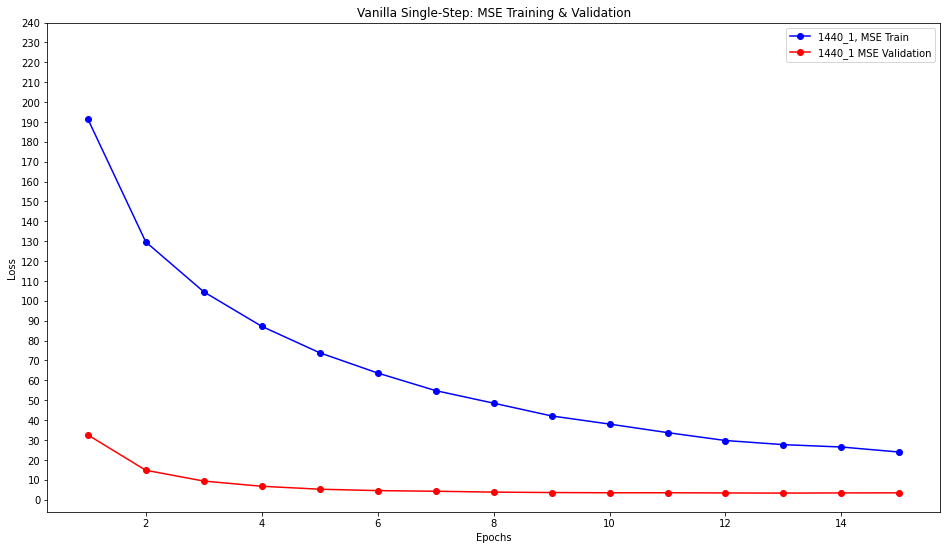

In [ ]:
loss = h_vanilla_ss1440_1['loss']
val_loss = h_vanilla_ss1440_1['val_loss']

epochs1 = range(1, len(loss) + 1)

fig = plt.figure(figsize=(16, 9))
plt.plot(epochs1, loss, 'bo-', label='1440_1, MSE Train')
plt.plot(epochs1, val_loss, 'ro-', label='1440_1 MSE Validation')
plt.title('Vanilla Single-Step: MSE Training & Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.yticks(ticks = range(0, 250, 10))
plt.show()

In [ ]:
deep_ss1440_1 = Sequential()
deep_ss1440_1.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
deep_ss1440_1.add(Dropout(0.1))

deep_ss1440_1.add(LSTM(32, activation='tanh', return_sequences=True))
deep_ss1440_1.add(Dropout(0.1))

deep_ss1440_1.add(LSTM(16, activation='tanh'))
deep_ss1440_1.add(Dropout(0.1))

deep_ss1440_1.add(Dense(32, activation='tanh'))
deep_ss1440_1.add(Dropout(0.1))

deep_ss1440_1.add(Dense(1))

opt = Adam(learning_rate = 0.001)

h_deep_ss1440_1 = single_compile_fit(deep_ss1440_1, X_train_reshaped, y_train)


60_1

In [ ]:
vanilla_ss60_1 = Sequential()
vanilla_ss60_1.add(LSTM(32, activation='tanh', return_sequences=False, input_shape=(n_steps, n_features)))
vanilla_ss60_1.add(Dropout(0.1))
vanilla_ss60_1.add(Dense(1))

opt = Adam(learning_rate = 0.001)

h_vanilla_ss60_1 = single_compile_fit(vanilla_ss60_1, X_train_reshaped, y_train)

In [55]:
vanilla_ss60_1 = load_model("vanilla_ss60_1.h5")

with open("h_vanilla_ss60_1.json") as f:
    h_vanilla_ss60_1 = json.load(f)

In [56]:
metrics(vanilla_ss60_1)

753/753 [==============================] - 3s 4ms/step
MSE: 17.905 RMSE: 4.231 MAPE: 0.052 MAE: 1.178


In [ ]:
deep_ss60_1 = Sequential()
deep_ss60_1.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
deep_ss60_1.add(Dropout(0.1))

deep_ss60_1.add(LSTM(32, activation='tanh', return_sequences=True))
deep_ss60_1.add(Dropout(0.1))

deep_ss60_1.add(LSTM(16, activation='tanh'))
deep_ss60_1.add(Dropout(0.1))

deep_ss60_1.add(Dense(32, activation='tanh'))
deep_ss60_1.add(Dropout(0.1))

deep_ss60_1.add(Dense(1))

opt = Adam(learning_rate = 0.001)

h_deep_ss60_1 = single_compile_fit(deep_ss60_1, X_train_reshaped, y_train)

In [57]:
deep_ss60_1 = load_model("deep_ss60_1.h5")

with open("h_deep_ss60_1.json") as f:
    h_deep_ss60_1 = json.load(f)

In [58]:
metrics(deep_ss60_1)

753/753 [==============================] - 5s 6ms/step
MSE: 21.726 RMSE: 4.661 MAPE: 0.069 MAE: 1.538


3_1

In [ ]:
vanilla_ss3_1 = Sequential()
vanilla_ss3_1.add(LSTM(32, activation='tanh', return_sequences=False, input_shape=(n_steps, n_features)))
vanilla_ss3_1.add(Dropout(0.1))
vanilla_ss3_1.add(Dense(1))

opt = Adam(learning_rate = 0.001)

h_vanilla_ss3_1 = single_compile_fit(vanilla_ss3_1, X_train_reshaped, y_train)

In [60]:
vanilla_ss3_1 = load_model("vanilla_ss3_1.h5")

with open("h_vanilla_ss3_1.json") as f:
    h_vanilla_ss3_1 = json.load(f)

In [61]:
metrics(vanilla_ss3_1)

755/755 [==============================] - 2s 3ms/step
MSE: 18.727 RMSE: 4.327 MAPE: 0.066 MAE: 1.485


In [ ]:
deep_ss3_1 = Sequential()
deep_ss3_1.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
deep_ss3_1.add(Dropout(0.1))

deep_ss3_1.add(LSTM(32, activation='tanh', return_sequences=True))
deep_ss3_1.add(Dropout(0.1))

deep_ss3_1.add(LSTM(16, activation='tanh'))
deep_ss3_1.add(Dropout(0.1))

deep_ss3_1.add(Dense(32, activation='tanh'))
deep_ss3_1.add(Dropout(0.1))

deep_ss3_1.add(Dense(1))

opt = Adam(learning_rate = 0.001)

h_deep_ss3_1 = single_compile_fit(deep_ss3_1, X_train_reshaped, y_train)

In [62]:
deep_ss3_1 = load_model("deep_ss3_1.h5")

with open("h_deep_ss3_1.json") as f:
    h_deep_ss3_1 = json.load(f)

In [63]:
metrics(deep_ss3_1)

755/755 [==============================] - 4s 5ms/step
MSE: 21.464 RMSE: 4.633 MAPE: 0.07 MAE: 1.609


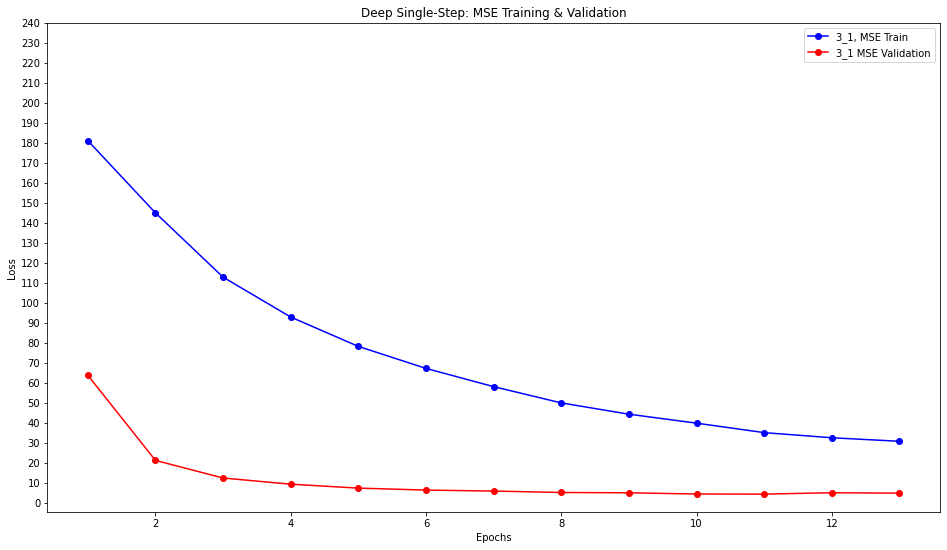

In [ ]:
loss = h_deep_ss3_1['loss']
val_loss = h_deep_ss3_1['val_loss']

epochs1 = range(1, len(loss) + 1)

fig = plt.figure(figsize=(16, 9))
plt.plot(epochs1, loss, 'bo-', label='3_1, MSE Train')
plt.plot(epochs1, val_loss, 'ro-', label='3_1 MSE Validation')
plt.title('Deep Single-Step: MSE Training & Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.yticks(ticks = range(0, 250, 10))
plt.show()

Saving Results

In [ ]:
vanillas_list = [
    ('vanilla_ss1440_1', h_vanilla_ss1440_1),
    ('vanilla_ss60_1', h_vanilla_ss60_1),
    ('vanilla_ss3_1', h_vanilla_ss3_1)]

ss_vanillas_dict = {}

for var_name, _ in vanillas_list:
    ss_vanillas_dict[var_name] = []

for var_name, element in vanillas_list:
    for key in element.keys():
        ss_vanillas_dict[var_name].append({key : element[key][-1]})

In [ ]:
deep_list = [
    ('deep_ss1440_1', h_deep_ss1440_1),
    ('deep_ss60_1', h_deep_ss60_1),
    ('deep_ss3_1', h_deep_ss3_1)]

ss_deep_dict = {}

for var_name, _ in deep_list:
    ss_deep_dict[var_name] = []

for var_name, element in deep_list:
    for key in element.keys():
        ss_deep_dict[var_name].append({key : element[key][-1]})

# Multi Step Approach

In [64]:
def split_sequence_multistep(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [80]:
n_steps_in = 1440
n_steps_out = 60
n_features = 1

X_train_m, y_train_m = split_sequence_multistep(train_df["gas"], n_steps_in, n_steps_out)
X_train_m_reshaped = X_train_m.reshape((X_train_m.shape[0], X_train_m.shape[1], n_features))
X_test_m, y_test_m = split_sequence_multistep(test_df["gas"], n_steps_in, n_steps_out)

X_test_m_reshaped = X_test_m.reshape((X_test_m.shape[0], X_test_m.shape[1], n_features))

In [ ]:
def multi_compile_fit(model, X_train_m_reshaped, y_train_m, checkpoint_path):

  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_path,
      save_weights_only=True,
      save_best_only=True,
      overwrite = True,
      monitor='val_loss',
      mode='min',
      verbose=1
  )

  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()])
  history = model.fit(
      X_train_m_reshaped, y_train_m,
      batch_size=32, epochs=MAX_EPOCHS,
      validation_split=0.2, shuffle=False,
      callbacks=[early_stopping, checkpoint_callback]
  )

  return history

In [66]:
def multi_metrics(model):

  MSE = mean_squared_error(model.predict(X_test_m_reshaped), y_test_m, squared = True)
  RMSE = mean_squared_error(model.predict(X_test_m_reshaped), y_test_m, squared = False)
  MAPE = mean_absolute_percentage_error(model.predict(X_test_m_reshaped), y_test_m)
  MAE = mean_absolute_error(model.predict(X_test_m_reshaped), y_test_m)

  return print("MSE: " + str(round(MSE, 3)) + " RMSE: " + str(round(RMSE, 3)) + " MAPE: "+ str(round(MAPE, 3)) + " MAE: " + str(round(MAE, 3)))

### Multi-Step Approach

###1440_60

In [ ]:
vanilla_ms1440_60 = Sequential()
vanilla_ms1440_60.add(LSTM(32, activation='tanh', return_sequences=False, input_shape=(n_steps_in, n_features)))
vanilla_ms1440_60.add(Dropout(0.1))
vanilla_ms1440_60.add(Dense(n_steps_out))

opt = Adam(learning_rate = 0.001)

h_vanilla_ms1440_60 = multi_compile_fit(vanilla_ms1440_60, X_train_m_reshaped, y_train_m)

In [67]:
vanilla_ms1440_60 = load_model("vanilla_ms1440_60.h5")

with open("h_vanilla_ms1440_60.json") as f:
    h_vanilla_ms1440_60 = json.load(f)

In [68]:
multi_metrics(vanilla_ms1440_60)

708/708 [==============================] - 12s 17ms/step
MSE: 106.911 RMSE: 10.312 MAPE: 0.198 MAE: 3.915


In [ ]:
deep_ms1440_60 = Sequential()
deep_ms1440_60.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features)))
deep_ms1440_60.add(Dropout(0.1))

deep_ms1440_60.add(LSTM(32, activation='tanh', return_sequences=True))
deep_ms1440_60.add(Dropout(0.1))

deep_ms1440_60.add(LSTM(16, activation='tanh'))
deep_ms1440_60.add(Dropout(0.1))

deep_ms1440_60.add(Dense(32, activation='tanh'))
deep_ms1440_60.add(Dropout(0.1))

deep_ms1440_60.add(Dense(n_steps_out))

opt = Adam(learning_rate = 0.001)

h_deep_ms1440_60 = multi_compile_fit(deep_ms1440_60, X_train_m_reshaped, y_train_m)

In [69]:
deep_ms1440_60 = load_model("deep_ms1440_60.h5")

with open("h_deep_ms1440_60.json") as f:
    h_deep_ms1440_60 = json.load(f)

In [70]:
multi_metrics(deep_ms1440_60)

708/708 [==============================] - 39s 55ms/step
MSE: 112.039 RMSE: 10.559 MAPE: 0.218 MAE: 4.21


### 60_60

In [ ]:
vanilla_ms60_60 = Sequential()
vanilla_ms60_60.add(LSTM(32, activation='tanh', return_sequences=False, input_shape=(n_steps_in, n_features)))
vanilla_ms60_60.add(Dropout(0.1))
vanilla_ms60_60.add(Dense(n_steps_out))

opt = Adam(learning_rate = 0.001)

h_vanilla_ms60_60 = multi_compile_fit(vanilla_ms60_60, X_train_m_reshaped, y_train_m)

In [73]:
vanilla_ms60_60 = load_model("vanilla_ms60_60.h5")

with open("h_vanilla_ms60_60.json") as f:
    h_vanilla_ms60_60 = json.load(f)

In [74]:
multi_metrics(vanilla_ms60_60)

751/751 [==============================] - 3s 3ms/step
MSE: 107.812 RMSE: 10.348 MAPE: 0.225 MAE: 4.234


In [ ]:
deep_ms60_60 = Sequential()
deep_ms60_60.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features)))
deep_ms60_60.add(Dropout(0.1))

deep_ms60_60.add(LSTM(32, activation='tanh', return_sequences=True))
deep_ms60_60.add(Dropout(0.1))

deep_ms60_60.add(LSTM(16, activation='tanh'))
deep_ms60_60.add(Dropout(0.1))

deep_ms60_60.add(Dense(32, activation='tanh'))
deep_ms60_60.add(Dropout(0.1))

deep_ms60_60.add(Dense(n_steps_out))

opt = Adam(learning_rate = 0.001)

h_deep_ms60_60 = single_compile_fit(deep_ms60_60, X_train_m_reshaped, y_train_m)

In [75]:
vanilla_ms60_60 = load_model("deep_ms60_60.h5")

with open("h_deep_ms60_60.json") as f:
    h_vanilla_ms60_60 = json.load(f)

In [76]:
multi_metrics(deep_ms60_60)

751/751 [==============================] - 3s 5ms/step
MSE: 185.068 RMSE: 13.604 MAPE: 0.522 MAE: 7.04


### Saving Variables

In [ ]:
vanillas_list = [
    ('vanilla_ms1440_60', h_vanilla_ms1440_60),
    ('vanilla_ms60_60', h_vanilla_ms60_60)]

ms_vanillas_dict = {}

for var_name, _ in vanillas_list:
    ms_vanillas_dict[var_name] = []

for var_name, element in vanillas_list:
    for key in element.keys():
        ms_vanillas_dict[var_name].append({key : element[key][-1]})

In [ ]:
deep_list = [
    ('deep_ms1440_60', h_deep_ms1440_60),
    ('deep_ms60_60', h_deep_ms60_60)]

ms_deep_dict = {}

for var_name, _ in deep_list:
    ms_deep_dict[var_name] = []

for var_name, element in deep_list:
    for key in element.keys():
        ms_deep_dict[var_name].append({key : element[key][-1]})


ms_vanillas_dict.update(ms_deep_dict)

ms_dict = ms_vanillas_dict

## Tuning Attempt

In [81]:
tuned_model = keras.models.load_model("tun2_deep_ms1440_60.h5")

In [82]:
tuned_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 1440, 100)         40800     
                                                                 
 lstm_38 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense_24 (Dense)            (None, 60)                6060      
                                                                 
Total params: 127,260
Trainable params: 127,260
Non-trainable params: 0
_________________________________________________________________


In [83]:
multi_metrics(tuned_model)

708/708 [==============================] - 24s 34ms/step
MSE: 113.634 RMSE: 10.628 MAPE: 0.222 MAE: 4.256


In [84]:
with open("tun2_deep_ms1440_60.json", "r") as file:
    h_tuned_model = json.load(file)

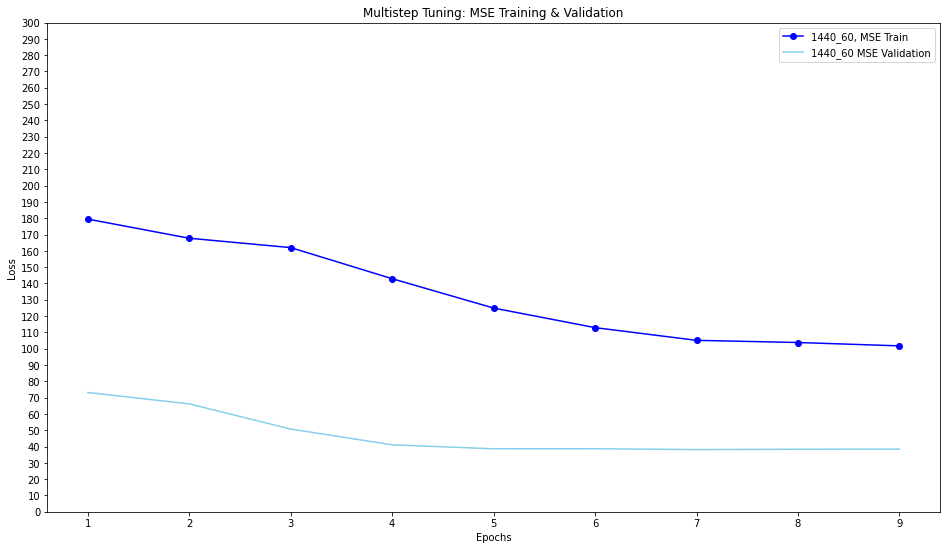

In [85]:
loss1 = h_tuned_model['loss']
val_loss1 = h_tuned_model['val_loss']

epochs1 = range(1, len(loss1) + 1)

fig = plt.figure(figsize=(16, 9))
plt.plot(epochs1, loss1, 'bo-', label='1440_60, MSE Train')
plt.plot(epochs1, val_loss1, 'skyblue', label='1440_60 MSE Validation')
plt.title('Multistep Tuning: MSE Training & Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.yticks(ticks = range(0, 301, 10))
plt.show()